<a href="https://colab.research.google.com/github/chom5621/ESAA/blob/main/(Kaggle)_Customers_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Mall Customers Segmentation** (쇼핑몰 고객 분할)



이 프로젝트는 머신러닝 알고리즘을 사용하여 쇼핑몰 고객 분할을 수행하는 방법을 보여줍니다: KMeans, Affinity Production(AP), DBSCAN 세 가지 기술이 사용됩니다. 알고리즘 변경 및 현재 개발/연구에 대한 추가 논의가 있을 예정이며, 주요 목적은 클러스터링 방법의 기본 사항을 다루고 심화 주제도 다루는 것입니다.

## **1. Introduction**

클러스터링(군집화)은 비지도학습에 속합니다.

클러스터링의 주요 작업은 레이블이 지정되지 않은 데이터 세트에서 "자연적" 그룹을 검색하는 것입니다. 이 작업은 많은 과학, 엔지니어링 및 비즈니스 애플리케이션에서 사용되므로 데이터 분석에서 중요한 작업입니다. 클러스터링의 가장 잘 알려진 적용 분야는 (효율적인 마케팅을 위한)고객 분할, 이미지 분할, 문서 군집화입니다. 계층적 군집화(Hierarchical Clustering) 및 분할적 군집화(Partitional Clustering)의 두 가지 주요 유형으로 나눌 수 있습니다:

* 계층적 군집화(Hierarchical Clustering)는 하위 집합이 하나의 항목만 포함할 때까지, 데이터 집합을 더 작은 하위 집합으로 반복적으로 분할합니다. 이것은 나무처럼 생긴 덴드로그램으로 나타낼 수 있습니다. 그것은 잎에서 뿌리로 혹은 뿌리부터 잎으로 구성될 수 있습니다. 계층적 군집분석에서는 군집 수를 지정할 필요는 없지만, 분할/합병 프로세스를 위한 종료 조건을 정의해야 합니다.

* 분할적 군집화(Partitional Clustering)는 주어진 기준에 따라 데이터 집합을 여러 하위 집합(클러스터)으로 나눕니다. 일부 알고리즘의 경우 클러스터 수를 사전(예: k-평균)으로 정의해야 하고 그렇지 않은 경우(DBSCAN)로 정의해야 합니다. 알고리즘을 실행하기 전에 클러스터 수를 정의하려면 종종 특정 도메인 지식이 필요한데, 이는 많은 응용 프로그램에서 어렵거나 불가능하기도 합니다. 따라서 도메인 지식 없이도 적절한 수의 클러스터를 선택할 수 있도록, 여러 발견적이고 단순화된 접근 방식이 개발되었습니다.

수많은 클러스터링 알고리즘이 존재하며 현재 다른 알고리즘을 지배하는 알고리즘은 없습니다. 최적의 선택은 데이터베이스 자체, 애플리케이션 도메인 및 클라이언트 요구사항과 기대에 따라 달라집니다. 이 노트북에서는 k-평균, DBSCAN, 선호도 그룹이라는 세 가지 분할적 군집화 알고리즘을 중점적으로 다룹니다. 모두 잘 알려진 Python 라이브러리인 Scikit-Learn에서 구현됩니다.

## **2. Reading Data**

데이터 클렌징이 필요한지 raw 데이터를 읽고, 검토하고, 확인합니다.

In [1]:
# importing basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

print("pandas version: {}".format(pd.__version__))
print("numpy version: {}".format(np.__version__))
print("seaborn version: {}".format(sns.__version__))

pandas version: 1.1.5
numpy version: 1.19.5
seaborn version: 0.11.2


In [2]:
mall_data = pd.read_csv('/content/drive/MyDrive/Mall_Customers.csv')

print('There are {} rows and {} columns in our dataset'.format(mall_data.shape[0],mall_data.shape[1]))

There are 200 rows and 5 columns in our dataset


In [3]:
mall_data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [4]:
mall_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


5 columns:
* Customer ID - numerical - unique customer number, integer
* Gender - categorical - binary (Male/Female)
* Age - numerical - integer
* Annual Income (k$) - numerical - integer
* Spending Score (1-100) - numerical - integer

There is one binary, categorical column: gender -> may be tempted to one-hot encode it for the clustering. It is technically possible and theoretically not forbidden, *but practically not recommended*.

K-Means를 사용한 이진 데이터 클러스터링(피해야 함)

In [5]:
mall_data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [6]:
mall_data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

결측값 없음. 이렇게 하면 분석이 간단해지지만, 분석가들이 코어 분석을 수행하기 전에 상당 시간을 들여 데이터를 청소하는 현실에서는 매우 가능성이 낮은 시나리오입니다.

## **3. Exploratory Data Analysis (EDA)**

이 섹션에는 주어진 데이터베이스에 대한 기본적인 통계 조사가 포함되어 있습니다. 기본 데이터를 더 잘 이해할 수 있기 때문에 모든 분석에서 중요한 부분입니다. 이 부분에는 Distributions(분포)와 Correlations(상관)이라는 두 가지 주요 섹션이 있습니다.

> ### **3.1 Distributions**

수치 변수의 분포에 대해 자세히 조사할 것입니다. 데이터는 유일한 범주형 변수인 성별에 따라 계층화됩니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


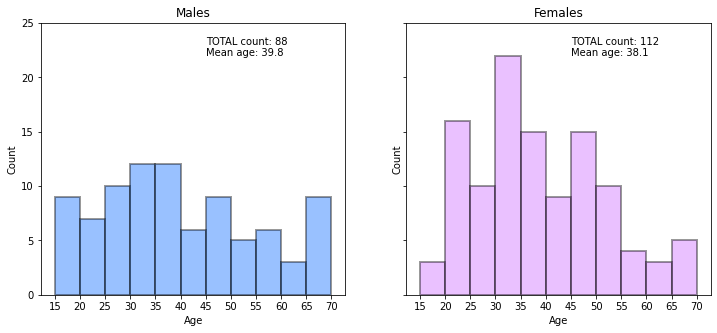

In [7]:
males_age = mall_data[mall_data['Gender']=='Male']['Age'] # subset with males age
females_age = mall_data[mall_data['Gender']=='Female']['Age'] # subset with females age

age_bins = range(15,75,5)

# males histogram
fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5), sharey=True)
sns.distplot(males_age, bins=age_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(age_bins)
ax1.set_ylim(top=25)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(45,23, "TOTAL count: {}".format(males_age.count()))
ax1.text(45,22, "Mean age: {:.1f}".format(males_age.mean()))

# females histogram
sns.distplot(females_age, bins=age_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(age_bins)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(45,23, "TOTAL count: {}".format(females_age.count()))
ax2.text(45,22, "Mean age: {:.1f}".format(females_age.mean()))

plt.show()

In [8]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_age, females_age)[1]))

Kolgomorov-Smirnov test p-value: 0.49


남성 고객의 평균 연령(39.8세)은 여성 고객(38.1세)보다 약간 높습니다. 남성 연령의 분포는 여성보다 균일한데, 여기서 가장 큰 연령대는 30-35세라는 것을 알 수 있습니다. Kolgomorov-Smirnov 검정에서는 이 두 그룹 간의 차이가 통계적으로 유의하지 않음을 보여줍니다.

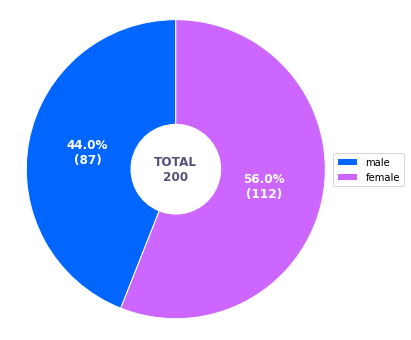

In [9]:
def labeler(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

sizes = [males_age.count(),females_age.count()] # wedge sizes

fig0, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(sizes,
                                   autopct=lambda pct: labeler(pct, sizes),
                                   radius=1,
                                   colors=['#0066ff','#cc66ff'],
                                   startangle=90,
                                   textprops=dict(color="w"),
                                   wedgeprops=dict(width=0.7, edgecolor='w'))

ax1.legend(wedges, ['male','female'],
           loc='center right',
           bbox_to_anchor=(0.7, 0, 0.5, 1))

plt.text(0,0, 'TOTAL\n{}'.format(mall_data['Age'].count()),
         weight='bold', size=12, color='#52527a',
         ha='center', va='center')

plt.setp(autotexts, size=12, weight='bold')
ax1.axis('equal')  # Equal aspect ratio
plt.show()

여성 고객(112명)이 남성 고객(87명)보다 조금 더 많습니다. 전체 고객의 56%가 여성입니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


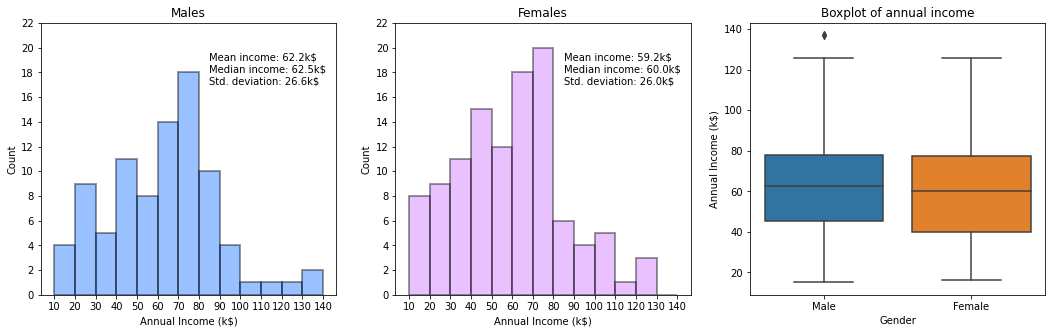

In [10]:
males_income = mall_data[mall_data['Gender']=='Male']['Annual Income (k$)'] # subset with males income
females_income = mall_data[mall_data['Gender']=='Female']['Annual Income (k$)'] # subset with females income

my_bins = range(10,150,10)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_income, bins=my_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(my_bins)
ax1.set_yticks(range(0,24,2))
ax1.set_ylim(0,22)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(85,19, "Mean income: {:.1f}k$".format(males_income.mean()))
ax1.text(85,18, "Median income: {:.1f}k$".format(males_income.median()))
ax1.text(85,17, "Std. deviation: {:.1f}k$".format(males_income.std()))

# females histogram
sns.distplot(females_income, bins=my_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(my_bins)
ax2.set_yticks(range(0,24,2))
ax2.set_ylim(0,22)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(85,19, "Mean income: {:.1f}k$".format(females_income.mean()))
ax2.text(85,18, "Median income: {:.1f}k$".format(females_income.median()))
ax2.text(85,17, "Std. deviation: {:.1f}k$".format(females_income.std()))

# boxplot
sns.boxplot(x='Gender', y='Annual Income (k$)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of annual income')
plt.show()

In [11]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_income, females_income)[1]))

Kolgomorov-Smirnov test p-value: 0.78


남성의 평균소득(62.2k\$)이 여성보다 높습니다(59.2k\$). 또한 남성 고객의 중위 소득(62.5k\$)이 여성 고객(60k\$)보다 높습니다. 표준 편차는 두 그룹 모두에서 유사합니다. 남성 그룹에는 약 140k\$의 연간 소득을 가진 특이치가 있습니다. K-S 검정 결과 이 두 그룹은 통계적으로 다르지 않습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


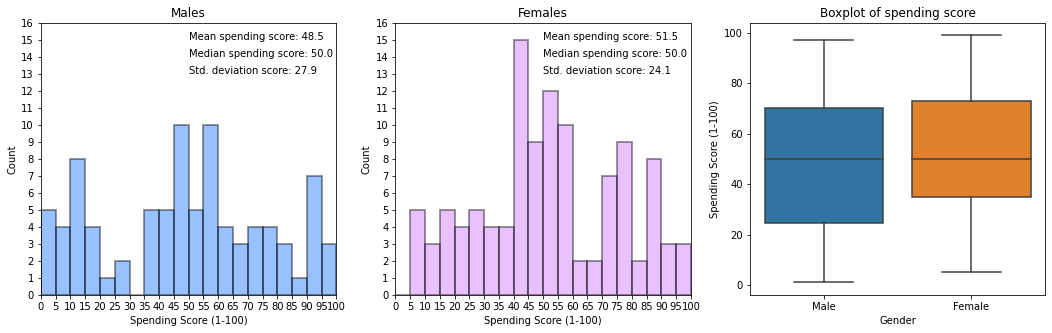

In [12]:
males_spending = mall_data[mall_data['Gender']=='Male']['Spending Score (1-100)'] # subset with males age
females_spending = mall_data[mall_data['Gender']=='Female']['Spending Score (1-100)'] # subset with females age

spending_bins = range(0,105,5)

# males histogram
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,5))
sns.distplot(males_spending, bins=spending_bins, kde=False, color='#0066ff', ax=ax1, hist_kws=dict(edgecolor="k", linewidth=2))
ax1.set_xticks(spending_bins)
ax1.set_xlim(0,100)
ax1.set_yticks(range(0,17,1))
ax1.set_ylim(0,16)
ax1.set_title('Males')
ax1.set_ylabel('Count')
ax1.text(50,15, "Mean spending score: {:.1f}".format(males_spending.mean()))
ax1.text(50,14, "Median spending score: {:.1f}".format(males_spending.median()))
ax1.text(50,13, "Std. deviation score: {:.1f}".format(males_spending.std()))

# females histogram
sns.distplot(females_spending, bins=spending_bins, kde=False, color='#cc66ff', ax=ax2, hist_kws=dict(edgecolor="k", linewidth=2))
ax2.set_xticks(spending_bins)
ax2.set_xlim(0,100)
ax2.set_yticks(range(0,17,1))
ax2.set_ylim(0,16)
ax2.set_title('Females')
ax2.set_ylabel('Count')
ax2.text(50,15, "Mean spending score: {:.1f}".format(females_spending.mean()))
ax2.text(50,14, "Median spending score: {:.1f}".format(females_spending.median()))
ax2.text(50,13, "Std. deviation score: {:.1f}".format(females_spending.std()))

# boxplot
sns.boxplot(x='Gender', y='Spending Score (1-100)', data=mall_data, ax=ax3)
ax3.set_title('Boxplot of spending score')
plt.show()

plt.show()

In [13]:
print('Kolgomorov-Smirnov test p-value: {:.2f}'.format(stats.ks_2samp(males_spending, females_spending)[1]))

Kolgomorov-Smirnov test p-value: 0.29


여성의 평균 지출 점수(51.5)가 남성(48.5)보다 높습니다. K-S 검정 p-값은 null-hypothesis를 기각할 증거가 없음을 나타내지만 이전 비교에서만큼 증거가 강하지는 않습니다. 다음으로 모든 연령대의 중위소득을 계산하겠습니다.

In [14]:
medians_by_age_group = mall_data.groupby(["Gender",pd.cut(mall_data['Age'], age_bins)]).median()
medians_by_age_group.index = medians_by_age_group.index.set_names(['Gender', 'Age_group'])
medians_by_age_group.reset_index(inplace=True)

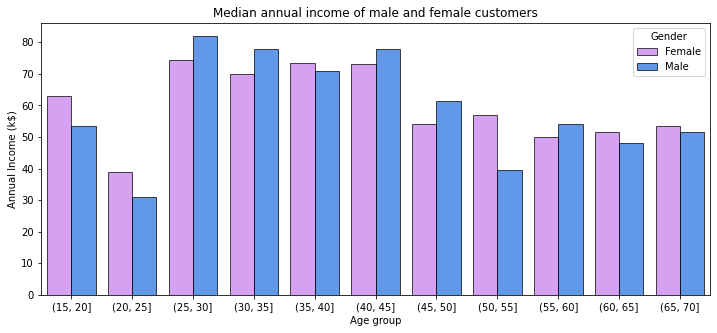

In [15]:
fig, ax = plt.subplots(figsize=(12,5))
sns.barplot(x='Age_group', y='Annual Income (k$)', hue='Gender', data=medians_by_age_group,
            palette=['#cc66ff','#0066ff'],
            alpha=0.7,edgecolor='k',
            ax=ax)
ax.set_title('Median annual income of male and female customers')
ax.set_xlabel('Age group')
plt.show()

위의 막대 그래프는 가장 부유한 고객의 연령대가 25-45세임을 보여줍니다. 여성과 남성의 가장 큰 차이는 25-30세(남성이 더 부유함)와 50-55세(여성이 더 부유함)에서 나타납니다.

> ### **3.2 Correlations**

숫자 변수 간의 상관 관계를 조사합니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


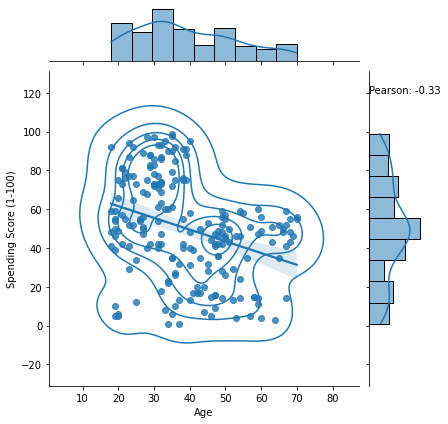

In [16]:
from scipy.stats import pearsonr

# calculating Pearson's correlation
corr, _ = pearsonr(mall_data['Age'], mall_data['Spending Score (1-100)'])

jp = (sns.jointplot('Age', 'Spending Score (1-100)', data=mall_data,
                    kind='reg')).plot_joint(sns.kdeplot, zorder=0, n_levels=6)

plt.text(0,120, 'Pearson: {:.2f}'.format(corr))
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


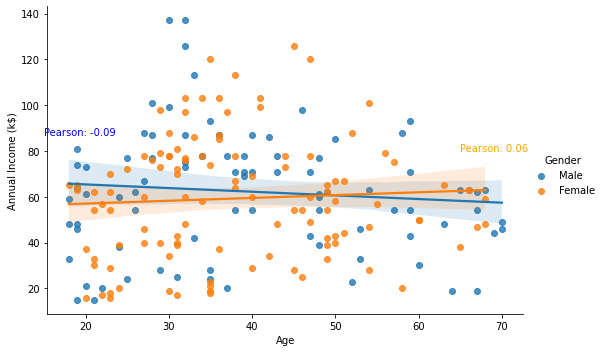

In [17]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_income.values)
corr2, _ = pearsonr(females_age.values, females_income.values)

sns.lmplot('Age', 'Annual Income (k$)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(15,87, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(65,80, 'Pearson: {:.2f}'.format(corr2), color='orange')

plt.show()

두 성별 그룹 모두 고객의 연령과 연간 소득 사이에는 상관관계가 거의 없습니다.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


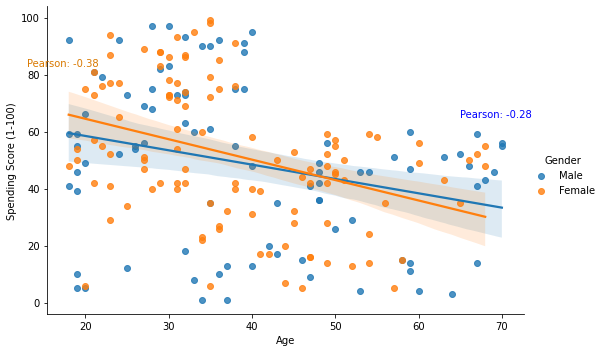

In [18]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_age.values, males_spending.values)
corr2, _ = pearsonr(females_age.values, females_spending.values)

sns.lmplot('Age', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(65,65, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(13,83, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

두 성별 그룹의 나이와 지출 점수 사이에는 약한 음의 상관관계(<0.5)가 있습니다.


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


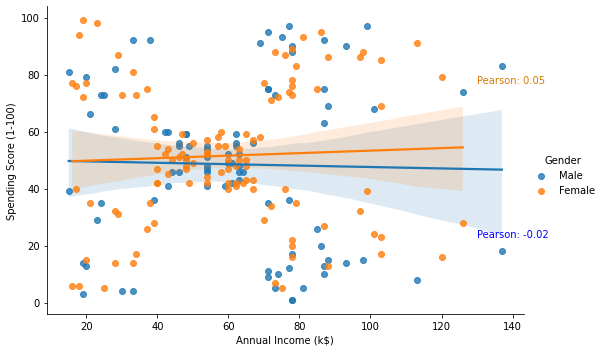

In [19]:
# calculating Pearson's correlations
corr1, _ = pearsonr(males_income.values, males_spending.values)
corr2, _ = pearsonr(females_income.values, females_spending.values)

sns.lmplot('Annual Income (k$)', 'Spending Score (1-100)', data=mall_data, hue='Gender',
          aspect=1.5)

plt.text(130,23, 'Pearson: {:.2f}'.format(corr1), color='blue')
plt.text(130,77, 'Pearson: {:.2f}'.format(corr2), color='#d97900')

plt.show()

두 성별 그룹 모두 고객의 연간 수입과 소비 점수 사이에는 상관관계가 거의 없습니다.


## **4. Clustering**

세 가지 클러스터링 알고리즘을 사용하는 방법을 설명하고 시연합니다.


> ### **4.1 K-Means**

대부분의 머신러닝 강좌에서 가르치고 있는 매우 인기 있는 K-평균 알고리즘에 초점을 맞추고 있습니다. 이 장에는 알고리즘에 대한 설명과 사용 사례(mall customer segmentation)의 두 가지 하위 장이 포함되어 있습니다.


>> #### **4.1.1 Description**

가장 잘 알려진 분할 군집화 알고리즘은 K-평균입니다. 50년대와 60년대에 여러 곳에서 독자적으로 개발되었으며 구현이 용이하고 단순하며 많은 경험적 성공(예: 비즈니스, 의학, 과학)으로 인해 큰 인기를 얻었습니다.

K-평균 알고리즘에는 다음과 같은 3가지 주요 단계가 있습니다(Lloyd's 알고리즘이라고도 함).

1. seed point를 사용하여 샘플을 초기 그룹으로 나눕니다. 이러한 seed point에서 가장 가까운 표본이 초기 군집을 생성합니다.
2. 그룹의 중심점(centroid)까지의 표본 거리를 계산하고 군집에 가장 가까운 표본을 할당합니다.
3. 세 번째 단계는 새로 생성된 (업데이트된) 클러스터 중심점을 계산하는 것입니다.
그런 다음 알고리즘이 수렴할 때까지 2단계와 3단계를 반복합니다.

앞에서 언급한 바와 같이 K-평균의 목표는 모든 클러스터에 대한 목적 함수 (inertia)를 최소화하는 것입니다. 목적 함수는 다음과 같이 정의됩니다.

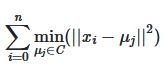

이것은 NP-hard problem으로 알려져 있는데, 이것은 greedy algorithm이고 local minimum으로 수렴된다는 것을 의미합니다. K-평균 알고리즘의 계산 비용은 O(kn)이며, 여기서 k는 군집 수이고 n은 표본 수입니다. 이는 다른 클러스터링 알고리즘과 비교했을 때 나쁘지 않습니다. 일반적으로 local minimum으로 수렴되지만, K-평균은 비교적 빠르며 그룹이 서로 잘 분리되면 global minimum으로 수렴될 가능성이 높습니다. 군집화의 결과는 초기화 기준에 따라 달라지기 때문에 다양한 초기화 지점에 대한 분석을 실행하고 inertia를 최소화한 지점을 선택하는 것이 일반적입니다. local minima algorithm 문제에 대한 몇 가지 개선점이 있습니다. 한 가지 예로, 개선된 점은 enhanced Firefly Algorithms을 사용하는 것입니다.

일반적으로 K-평균 알고리즘에서는 다음과 같은 세 가지 주요 파라미터를 정의해야 합니다.

1. 초기화 기준: Scikit-learn에서는 Arthur and Vassilvitskii가 제안한 "k-means++"이라는 현명한 초기화 체계가 구현됩니다. 이것은 일반적으로 서로 멀리 떨어져 있는 초기 중심을 만들어 더 나은 결과를 얻을 확률을 높입니다. Random point generator를 사용할 수도 있습니다. K-평균 알고리즘에 대한 가장 효율적인 seeding 방법을 만들기 위한 지속적인 노력이 있는데, 그 중 하나는 Independent Component Analysis을 기반으로 합니다.

2. 군집 수: 클러스터 수를 선택하는 것이 이 알고리즘을 설정할 때 가장 어려운 부분입니다. 이에 대한 엄격한 수학적 기준은 없으며 많은 직관적이고/간단한 접근법이 개발되었습니다. 가장 간단하고 가장 인기 있는 방법 중 하나는 이 분석에 나타난 elbow 방법입니다. 추가로 실루엣 점수도 사용됩니다. 최적의 클러스터 수를 선택하기 위한 다른 고급 옵션도 있습니다(그러나 이 노트북에서는 사용되지 않고 sklearn에서는 구현되지 않음):
  - Minimum Message Length (MML)
  - Minimum Description Length (MDL)
  - Bayes Information Criterion (BIC)
  - Akaike Information Criterion (AIC)
  - Dirichlet Process
  - Gap statistics

3. 거리 메트릭(Scikit Learn 구현에는 필요하지 않습니다): 점 사이의 거리를 계산하기 위한 다양한 옵션이 있습니다. 가장 인기 있는 것은 단순 유클리드 측정법이며 scikit-learn에 구현된 것입니다. 종종 구형 k-평균 모형이라고 불리고, 구형과 유사한 그룹만 발견하며 고차원 분석("차원성의 곡선")에서 부풀어 오르는 경향이 있다는 단점이 있습니다. scikit-learn에는 구현되지 않은 다른 옵션이 있습니다:
  - Mahalonobis distance (high computiational cost)
  - Itakura-Saito distance
  - L1 distance
  - Cosine distance
  - Bregman distance

K-Means에 제안된 수많은 연구와 변형이 있습니다:
* K-Medoid where the centroid is defined as the most centrally located object)
* K-Median where the centroid is calculated using median instead of a mean,
* Fuzzy C-means model

K-Means에 대한 몇 가지 논쟁은 다음과 같습니다:
* Euclidean distances are used
* Number of clusters has to be defined for the algorithm
* Centroid is calculated using mean distance to cluster members
* Clusters are assumed isotropic and convex
* Stochastic algorithm – results depend on the initialisation criteria
* Creates groups of equal variance (minimises inertia)
* Prone to the “curse of dimensionality”
* Can be run in parallel – so it scales well

>> #### **4.1.2 Use case - customers segmentation**

군집화 분석의 첫 번째 단계는 sklearn 라이브러리에서 K-평균을 가져오는 것입니다.

In [20]:
from sklearn.cluster import KMeans 

군집화에는 숫자 열만 사용됩니다.

In [21]:
X_numerics = mall_data[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']] # subset with numeric variables only

적절한 수의 군집을 찾기 위해 elbow 방법이 사용됩니다. 이 경우 2와 10 사이의 군집 수에 대한 inertia이 계산됩니다. 그래프에서 구부러지거나 "elbow"가 나타나는 군집 수를 선택하는 것이 규칙입니다.


In [22]:
from sklearn.metrics import silhouette_score
n_clusters = [2,3,4,5,6,7,8,9,10] # number of clusters
clusters_inertia = [] # inertia of clusters
s_scores = [] # silhouette scores

for n in n_clusters:
    KM_est = KMeans(n_clusters=n, init='k-means++').fit(X_numerics)
    clusters_inertia.append(KM_est.inertia_)    # data for the elbow method
    silhouette_avg = silhouette_score(X_numerics, KM_est.labels_)
    s_scores.append(silhouette_avg) # data for the silhouette score method

아래 그래프는 선택된 군집 범위에 대한 inertia을 보여 줍니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


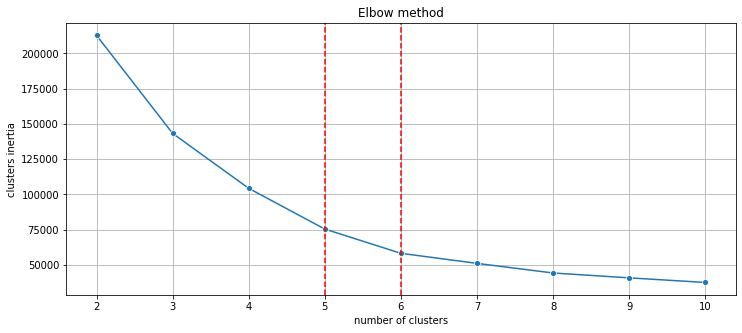

In [23]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, clusters_inertia, marker='o', ax=ax)
ax.set_title("Elbow method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("clusters inertia")
ax.axvline(5, ls="--", c="red")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

뚜렷한 "elbow"가 보이지 않습니다. 5개 또는 6개 클러스터 중에서 선택하는 것이 공평할 것 같습니다. 실루엣 점수를 보겠습니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


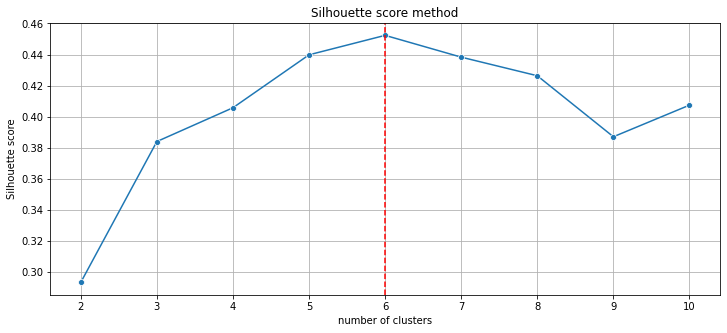

In [24]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(n_clusters, s_scores, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(6, ls="--", c="red")
plt.grid()
plt.show()

실루엣 점수 방법은 각각 6개 또는 5개의 군집이 가장 좋은 옵션임을 나타냅니다. 두 개 다 비교해 보죠.
* **5 CLUSTERS**

In [25]:
KM_5_clusters = KMeans(n_clusters=5, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM5_clustered = X_numerics.copy()
KM5_clustered.loc[:,'Cluster'] = KM_5_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


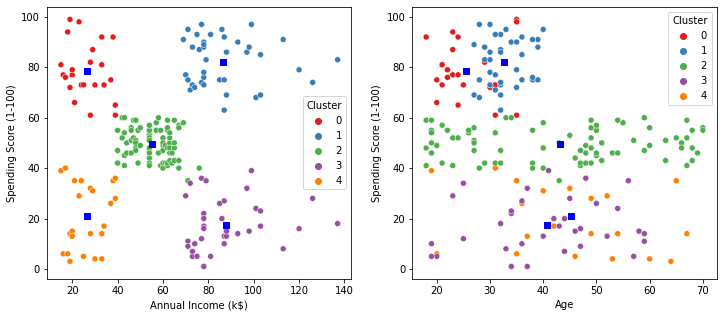

In [26]:
fig1, (axes) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM5_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

axes[0].scatter(KM_5_clusters.cluster_centers_[:,1],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_5_clusters.cluster_centers_[:,0],KM_5_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-평균 알고리즘은 다음과 같은 5개의 군집을 생성했습니다.

0. 연간 소득이 낮고 지출 점수가 높은 고객입니다.
1. 중간 연 소득 및 중간 지출 점수를 가진 고객입니다.
2. 연간 소득이 높고 지출 점수가 낮은 고객입니다.
3. 높은 연간 수입과 높은 지출 점수를 가진 고객입니다.
4. 고객의 연간 수입과 지출 점수가 낮습니다.

고객 연령대에는 뚜렷한 그룹이 없습니다.

클러스터별 크기는 다음과 같습니다:

In [27]:
KM_clust_sizes = KM5_clustered.groupby('Cluster').size().to_frame()
KM_clust_sizes.columns = ["KM_size"]
KM_clust_sizes

,KM_size
Cluster,
0,23
1,39
2,79
3,36
4,23


가장 큰 군집은 관측치가 79개인 1번 군집("중간" 클라이언트)입니다. 각각 23개의 관측치를 포함하는 가장 작은 두 개의 관측치(군집 3 "높고-높은" 및 군집 0 "낮고-높은" 클라이언트)가 있습니다. 아래에는 생성된 5개의 클러스터가 3D 투영되어 있습니다. 정적 모드의 시각화 측면에서는 유용하지 않지만 대화형 환경(예: Spyder)에서 코드를 실행할 경우 코드를 회전시킬 수 있습니다!


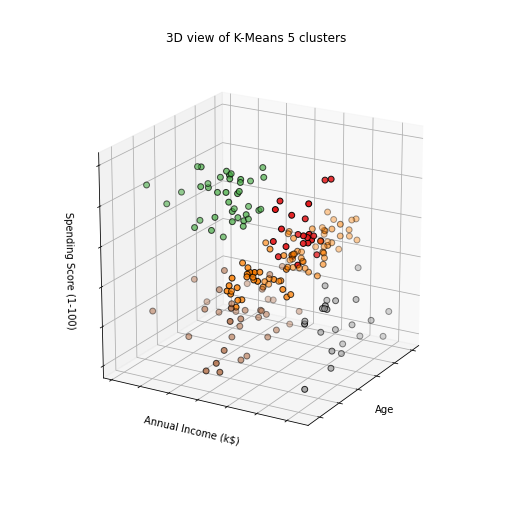

In [28]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(KM5_clustered['Age'],
           KM5_clustered['Annual Income (k$)'],
           KM5_clustered['Spending Score (1-100)'],
           c=KM5_clustered['Cluster'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
ax.set_title('3D view of K-Means 5 clusters')
ax.dist = 12

plt.show()

아래는 Plotly 버전입니다:

In [29]:
import plotly as py
import plotly.graph_objs as go

def tracer(db, n, name):
    '''
    This function returns trace object for Plotly
    '''
    return go.Scatter3d(
        x = db[db['Cluster']==n]['Age'],
        y = db[db['Cluster']==n]['Spending Score (1-100)'],
        z = db[db['Cluster']==n]['Annual Income (k$)'],
        mode = 'markers',
        name = name,
        marker = dict(
            size = 5
        )
     )

trace0 = tracer(KM5_clustered, 0, 'Cluster 0')
trace1 = tracer(KM5_clustered, 1, 'Cluster 1')
trace2 = tracer(KM5_clustered, 2, 'Cluster 2')
trace3 = tracer(KM5_clustered, 3, 'Cluster 3')
trace4 = tracer(KM5_clustered, 4, 'Cluster 4')

data = [trace0, trace1, trace2, trace3, trace4]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

* **6 CLUSTERS**

In [30]:
KM_6_clusters = KMeans(n_clusters=6, init='k-means++').fit(X_numerics) # initialise and fit K-Means model

KM6_clustered = X_numerics.copy()
KM6_clustered.loc[:,'Cluster'] = KM_6_clusters.labels_ # append labels to points

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



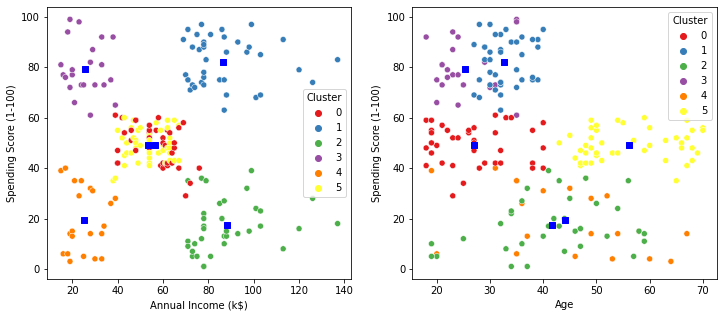

In [31]:
fig11, (axes) = plt.subplots(1,2,figsize=(12,5))

sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', ax=axes[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=KM6_clustered,
                hue='Cluster', palette='Set1', ax=axes[1], legend='full')

# plotting centroids
axes[0].scatter(KM_6_clusters.cluster_centers_[:,1], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
axes[1].scatter(KM_6_clusters.cluster_centers_[:,0], KM_6_clusters.cluster_centers_[:,2], marker='s', s=40, c="blue")
plt.show()

K-평균 알고리즘은 다음과 같은 6개의 군집을 생성했습니다.

0. **중간** 연간 및 **중간** 지출 점수가 있는 젊은 고객입니다.
1. **높은** 연소득과 **낮은** 지출 점수를 가진 고객입니다.
2. **중간** 연간 및 **중간** 지출 점수가 있는 젊은 고객입니다.
3. **고액** 연소득 및 **고액** 소비성적이 있는 고객입니다.
4. 연소득이 **낮고** 지출 점수가 **낮은** 고객입니다.
5. **낮은** 연소득과 **높은** 지출 점수를 가진 고객입니다.

고객 연령대에는 뚜렷한 그룹이 없습니다.

클러스터별 크기는 다음과 같습니다:

In [32]:
KM6_clust_sizes = KM6_clustered.groupby('Cluster').size().to_frame()
KM6_clust_sizes.columns = ["KM_size"]
KM6_clust_sizes

,KM_size
Cluster,
0,38
1,39
2,35
3,22
4,21
5,45


In [33]:
# Plotly interactive 3D plot

trace0 = tracer(KM6_clustered, 0, 'Cluster 0')
trace1 = tracer(KM6_clustered, 1, 'Cluster 1')
trace2 = tracer(KM6_clustered, 2, 'Cluster 2')
trace3 = tracer(KM6_clustered, 3, 'Cluster 3')
trace4 = tracer(KM6_clustered, 4, 'Cluster 4')
trace5 = tracer(KM6_clustered, 5, 'Cluster 5')

data = [trace0, trace1, trace2, trace3, trace4, trace5]

layout = go.Layout(
    title = 'Clusters by K-Means',
    scene = dict(
            xaxis = dict(title = 'Age'),
            yaxis = dict(title = 'Spending Score'),
            zaxis = dict(title = 'Annual Income')
        )
)

fig = go.Figure(data=data, layout=layout)
py.offline.iplot(fig)

> ### **4.2 DBSCAN**

DBSCAN(Density-Based Spatial Clustering of Applications with Noise)의 작동 방식을 설명하고 쇼핑몰 고객 분할에 대한 구현을 보여줍니다.

>> #### **4.2.1 Description**

DBSCAN은 노이즈가 있는 응용프로그램의 밀도 기반 공간 클러스터링의 약자로, scikit-learn 라이브러리에서 구현되는 클러스터링 알고리즘 중 하나입니다. 1996년 Martin Ester, Hans-Peter Kriegel, Jörg Sander, Xiaowei Xu가 "소음이 있는 대형 공간 데이터베이스에서 성단을 발견하기 위한 밀도 기반 알고리즘"이라는 유명한 논문에서 제안했습니다.

DBSCAN의 핵심 아이디어는 밀집 지역의 개념에 관한 것입니다. 자연 군집은 점들이 밀집되어 있다고 가정합니다. 이를 위해서는 "밀도 지역"의 정의가 필요합니다. 이 작업을 수행하려면 DBSCAN 알고리즘에 두 개의 매개변수가 필요합니다.

* Eps, ε - distance
* MinPts – Minimum number of points within distance Eps

거리 메트릭은 선택적으로 사용자가 지정할 수 있지만 일반적으로 scikit 학습에서처럼 유클리드 거리가 구현됩니다.

따라서 "밀도 영역"은 모든 점 사이의 거리 내에 있는 최소 점의 수, 즉 Eps에 의해 생성됩니다. 이 거리 내에 있지만 다른 점의 최소 개수에 가깝지 않은 점은 "경계점"으로 간주됩니다. 나머지 하나는 잡음 또는 특이치입니다. 아래 그림에 표시되어 있습니다(MinPt=3의 경우). 빨간색 점(D)은 "밀도 영역"에 속합니다. 각 점은 거리 Eps 내에 최소 3개의 이웃을 가지고 있습니다. 녹색 지점(B)은 경계 지점입니다. 즉, Eps 거리 내에 인접하지만 3개 미만입니다. 파란색 점(O)은 특이치로, 거리 Eps 내에 이웃이 없습니다.

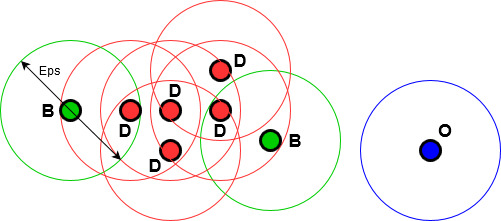

이 접근 방식의 장점은 다음과 같습니다:

* Eps 및 MinPts 매개 변수를 기반으로 군집 수를 찾습니다.
* 이것은 늘어진 성단 또는 다른 성단에 둘러싸인 성단을 구별할 수 있습니다(예: 성단이 항상 볼록한 K-평균).
* 또한 특이치를 탐지하여 어떤 군집에도 적합되지 않는 점을 찾을 수 있습니다.

DBSCAN의 가장 큰 단점은 다음과 같습니다:
* 평균 O(n log(n))의 높은 계산 비용은 각 지점에 대한 인접 쿼리를 실행해야 하기 때문입니다.
* 밀도가 다양한 클러스터를 제대로 식별하지 못합니다.

기계 학습 연구자들이 DBSCAN 알고리즘에 제안한 다양한 변형과 확장이 있습니다. 예를 들어 다음과 같습니다:
* W. Jing, Ch. Zhao와 Ch. Jing은 "클라우드 컴퓨팅에 대한 DBSCAN 알고리즘의 개선 방법"을 제안했습니다. 확장성의 문제를 해결할 수 있습니다.
* H.You, L. Chen과 J. Yao, X. Wang은 다양한 밀도를 가진 클러스터의 문제를 극복하기 위해 "향상된 DBSCAN 알고리즘을 기반으로 한 3방향 클러스터링 방법"을 제안했습니다.

>> #### **4.2.2 Use case - customers segmentation**

첫 번째 단계는 sklearn에서 DBSCAN을 가져오는 것입니다.


In [34]:
from sklearn.cluster import DBSCAN

알고리즘 매개 변수의 최적의 조합을 선택하기 위해, 먼저 조사된 조합의 행렬을 만들겠습니다.

In [35]:
from itertools import product

eps_values = np.arange(8,12.75,0.25) # eps values to be investigated
min_samples = np.arange(3,10) # min_samples values to be investigated
DBSCAN_params = list(product(eps_values, min_samples))

생성된 클러스터 수를 취합합니다.

In [36]:
no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(X_numerics)
    no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
    sil_score.append(silhouette_score(X_numerics, DBS_clustering.labels_))

아래 히트맵은 각 모수 조합의 알고리즘에 의해 생성된 군집 수를 보여 줍니다.


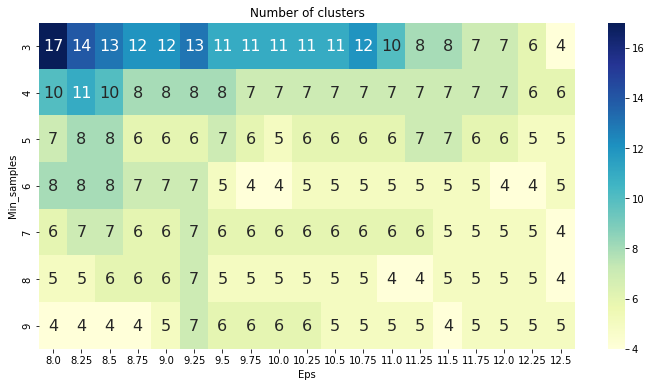

In [37]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

위의 히트맵에서 알 수 있듯이 군집 수는 17개에서 4개까지 다양합니다.


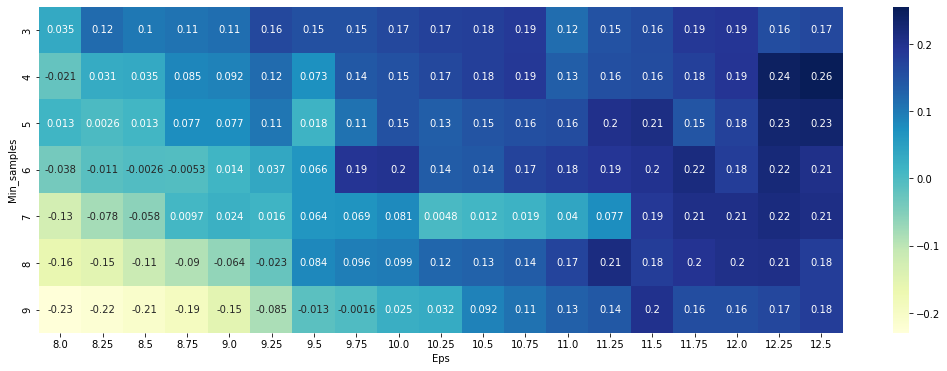

In [38]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Global maximum is 0.26 for eps=12.5 and min_samples=4.

In [39]:
DBS_clustering = DBSCAN(eps=12.5, min_samples=4).fit(X_numerics)

DBSCAN_clustered = X_numerics.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points

클러스터별 크기:

In [40]:
DBSCAN_clust_sizes = DBSCAN_clustered.groupby('Cluster').size().to_frame()
DBSCAN_clust_sizes.columns = ["DBSCAN_size"]
DBSCAN_clust_sizes

,DBSCAN_size
Cluster,
-1,18
0,112
1,8
2,34
3,24
4,4


DBSCAN은 5개의 군집과 특이치 군집(-1)을 만들었습니다. 0-4 군집의 크기는 상당히 다양합니다: 일부 군집에는 4개 또는 8개의 관측치만 있습니다. 특이치는 18개입니다.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



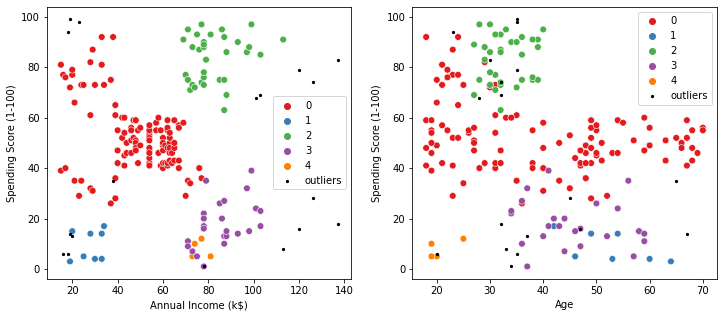

In [41]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

fig2, (axes) = plt.subplots(1,2,figsize=(12,5))


sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', ax=axes[0], palette='Set1', legend='full', s=45)

sns.scatterplot('Age', 'Spending Score (1-100)',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', ax=axes[1], legend='full', s=45)

axes[0].scatter(outliers['Annual Income (k$)'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[1].scatter(outliers['Age'], outliers['Spending Score (1-100)'], s=5, label='outliers', c="k")
axes[0].legend()
axes[1].legend()

plt.setp(axes[0].get_legend().get_texts(), fontsize='10')
plt.setp(axes[1].get_legend().get_texts(), fontsize='10')

plt.show()

위의 그래프는 일부 특이치가 있음을 보여 주며, 이러한 특이치는 거리 및 군집으로 인식되기 위한 최소 표본 요구 사항을 충족하지 않습니다.


> ### **4.3 Affinity Propagation**

이 장에서는 유사도 전파의 작동 방식을 설명하고 쇼핑몰 고객 분할에 대한 구현을 보여줍니다.

>> #### **4.3.1 Description**

유사도 전파(AP)는 2007년 Brendan Frey와 Delbert Dueck가 처음으로 제안한 클러스터링 알고리즘입니다("데이터 포인트 간 메시지 전달에 의한 클러스터링"). 이것은 수렴될 때까지 한 쌍의 점 사이에 메시지를 보내는 개념을 중심으로 구축됩니다. 이 메시지들은 이 두 점들이 서로 얼마나 비슷한지 측정하는 방법이며, 서로 모범이 될 수 있습니다. 이 알고리즘은 최적의 클러스터 수를 자체적으로 찾습니다. 이는 또한 O(n²T) 차수의 매우 높은 시간 복잡성 비용을 의미하며, 여기서 n은 표본의 수이고 T는 수렴까지의 반복 횟수입니다. 하지만, AP의 큰 장점은 초기화 기준에 대한 민감도가 부족하다는 것입니다.

사용자는 다음 두 가지 파라미터를 지정해야 합니다:
* 선호도(Preference)는 음수이며 사용되는 예시 수를 제어합니다.
* 댐핑 계수(Damping factor)는 메시지 업데이트 시 수치 진동을 방지합니다.

다른 알고리즘과 마찬가지로 이를 개선하기 위한 지속적인 노력이 있습니다:
* P.Ling과 그의 팀은 요소 선호도 계산의 개선으로 더 나은 클러스터링 결과를 얻을 수 있는 "조정 가능한 선호도 전파(APAP)" 알고리즘을 제안했습니다.
* H. Wenlong과 그의 팀은 매우 작은 데이터 세트의 경우 현재 알고리즘을 능가하는 "전송 친화력 전파 기반 클러스터링"을 제안했습니다.

>> #### **4.3.2 Use case - customers segmentation**

In [42]:
from sklearn.cluster import AffinityPropagation

In [48]:
no_of_clusters = []
preferences = range(-20000,-5000,100) # arbitraty chosen range
af_sil_score = [] # silouette scores
p_lst = []

for p in preferences:
    AF = AffinityPropagation(preference=p, max_iter=200).fit(X_numerics)
    if len(np.unique(AF.labels_)) >= 2 :
        no_of_clusters.append((len(np.unique(AF.labels_))))
        af_sil_score.append(silhouette_score(X_numerics, AF.labels_))
        p_lst.append(p)
    
af_results = pd.DataFrame([preferences, no_of_clusters, af_sil_score], index=['preference','clusters', 'sil_score']).T
af_results.sort_values(by='sil_score', ascending=False).head() # display only 5 best scores

/usr/local/lib/python3.7/dist-packages/sklearn/cluster/_affinity_propagation.py:253: ConvergenceWarning:

Affinity propagation did not converge, this model will not have any cluster centers.



,preference,clusters,sil_score
81,-11900.0,6.0,0.451649
27,-17300.0,6.0,0.451491
51,-14900.0,6.0,0.451491
37,-16300.0,6.0,0.451440
64,-13600.0,6.0,0.451440


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



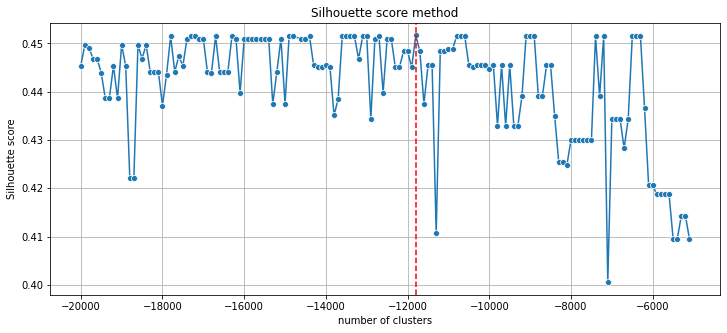

In [49]:
fig, ax = plt.subplots(figsize=(12,5))
ax = sns.lineplot(p_lst, af_sil_score, marker='o', ax=ax)
ax.set_title("Silhouette score method")
ax.set_xlabel("number of clusters")
ax.set_ylabel("Silhouette score")
ax.axvline(-11800, ls="--", c="red")
plt.grid()
plt.show()

In [50]:
AF = AffinityPropagation(preference=-11800).fit(X_numerics)

In [51]:
AF_clustered = X_numerics.copy()
AF_clustered.loc[:,'Cluster'] = AF.labels_ # append labels to points

In [52]:
AF_clust_sizes = AF_clustered.groupby('Cluster').size().to_frame()
AF_clust_sizes.columns = ["AF_size"]
AF_clust_sizes

,AF_size
Cluster,
0,22
1,22
2,44
3,39
4,34
5,39


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



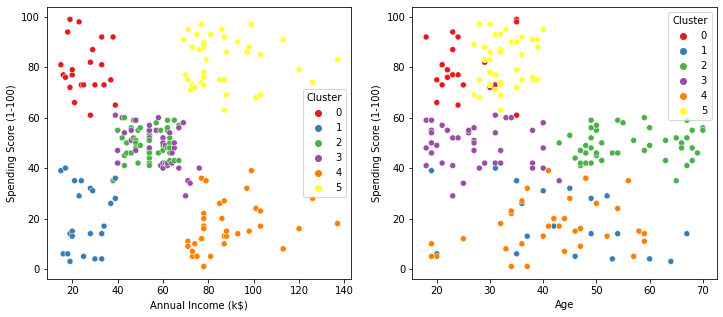

In [53]:
fig3, (ax_af) = plt.subplots(1,2,figsize=(12,5))


scat_1 = sns.scatterplot('Annual Income (k$)', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', ax=ax_af[0], palette='Set1', legend='full')

sns.scatterplot('Age', 'Spending Score (1-100)', data=AF_clustered,
                hue='Cluster', palette='Set1', ax=ax_af[1], legend='full')

plt.setp(ax_af[0].get_legend().get_texts(), fontsize='10')
plt.setp(ax_af[1].get_legend().get_texts(), fontsize='10')
plt.show()

선호도 전파 알고리즘으로 생성된 클러스터는 K-평균에서 생성된 클러스터와 유사한 비교적 짝수 크기의 클러스터를 생성합니다.

## **5. Comparison and discussion**

이 챕터에서는 3개의 조사된 알고리즘에 의해 유전자 처리된 클러스터를 비교하고 논의합니다.


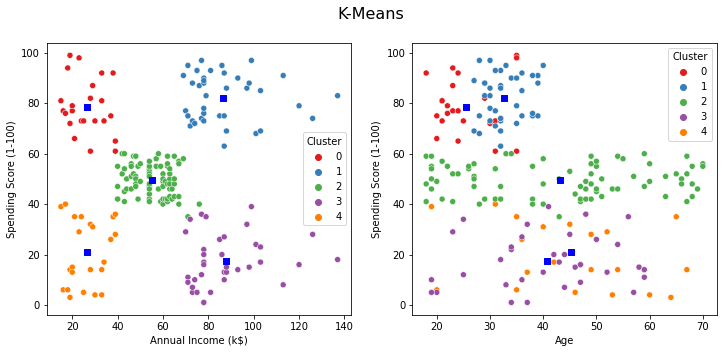

In [54]:
fig1.suptitle('K-Means', fontsize=16)
fig1

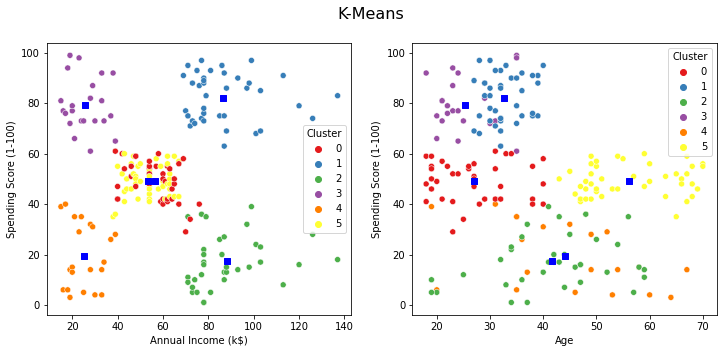

In [55]:
fig11.suptitle('K-Means', fontsize=16)
fig11

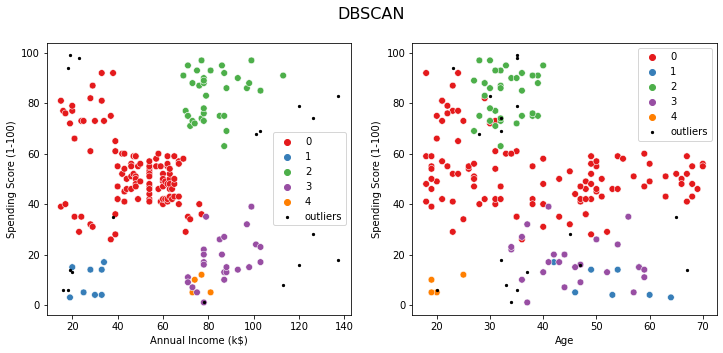

In [56]:
fig2.suptitle('DBSCAN', fontsize=16)
fig2

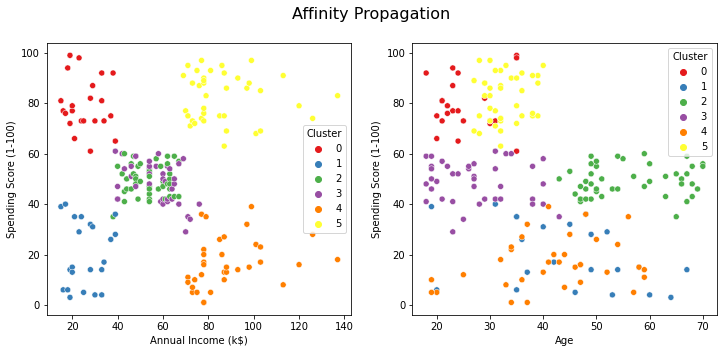

In [57]:
fig3.suptitle('Affinity Propagation', fontsize=16)
fig3

아래 표에는 생성된 클러스터의 크기가 나와 있습니다. 클러스터 번호는 각 방법마다 다릅니다. 예를 들어 K-평균의 클러스터 0번은 DBSCAN의 클러스터 2번과 선호도 전파의 클러스터 2번과 동일합니다.

In [58]:
clusters = pd.concat([KM6_clust_sizes, DBSCAN_clust_sizes, AF_clust_sizes],axis=1, sort=False)
clusters

,KM_size,DBSCAN_size,AF_size
Cluster,,,
-1,NaN,18.0,NaN
0,38.0,112.0,22.0
1,39.0,8.0,22.0
2,35.0,34.0,44.0
3,22.0,24.0,39.0
4,21.0,4.0,34.0
5,45.0,NaN,39.0


위의 비교 결과, DBSCAN은 합리적인 클러스터를 생성하지 못했습니다. 이는 다양한 밀도의 클러스터(이 경우 존재하는 클러스터)를 인식하는 데 문제가 있기 때문입니다.

K-평균 및 선호도 전파 알고리즘은 합리적인 6개의 클러스터를 만들었습니다.